🔥 Using device: cuda
Iter 0, Total Loss: 3.926e+05, PDE: 3.926e+05, BC: 3.568e-01, SRC: 5.446e-01
Iter 2000, Total Loss: 6.119e+01, PDE: 5.622e+01, BC: 5.331e-04, SRC: 9.928e-01
Iter 4000, Total Loss: 4.587e+01, PDE: 4.088e+01, BC: 1.240e-04, SRC: 9.990e-01
Iter 6000, Total Loss: 6.191e+00, PDE: 1.195e+00, BC: 7.547e-06, SRC: 9.991e-01
Iter 8000, Total Loss: 5.259e+00, PDE: 2.631e-01, BC: 2.113e-06, SRC: 9.991e-01
Iter 10000, Total Loss: 5.113e+00, PDE: 1.177e-01, BC: 6.045e-07, SRC: 9.991e-01
Iter 12000, Total Loss: 5.028e+00, PDE: 3.230e-02, BC: 1.403e-07, SRC: 9.991e-01
Iter 14000, Total Loss: 5.009e+00, PDE: 1.375e-02, BC: 4.167e-08, SRC: 9.991e-01
Iter 16000, Total Loss: 5.001e+00, PDE: 5.440e-03, BC: 1.443e-08, SRC: 9.991e-01
Iter 18000, Total Loss: 4.998e+00, PDE: 2.021e-03, BC: 1.699e-09, SRC: 9.991e-01
Iter 20000, Total Loss: 4.997e+00, PDE: 8.657e-04, BC: 4.692e-10, SRC: 9.991e-01
Iter 22000, Total Loss: 5.011e+00, PDE: 1.491e-02, BC: 1.462e-08, SRC: 9.992e-01
Iter 24000, Tot

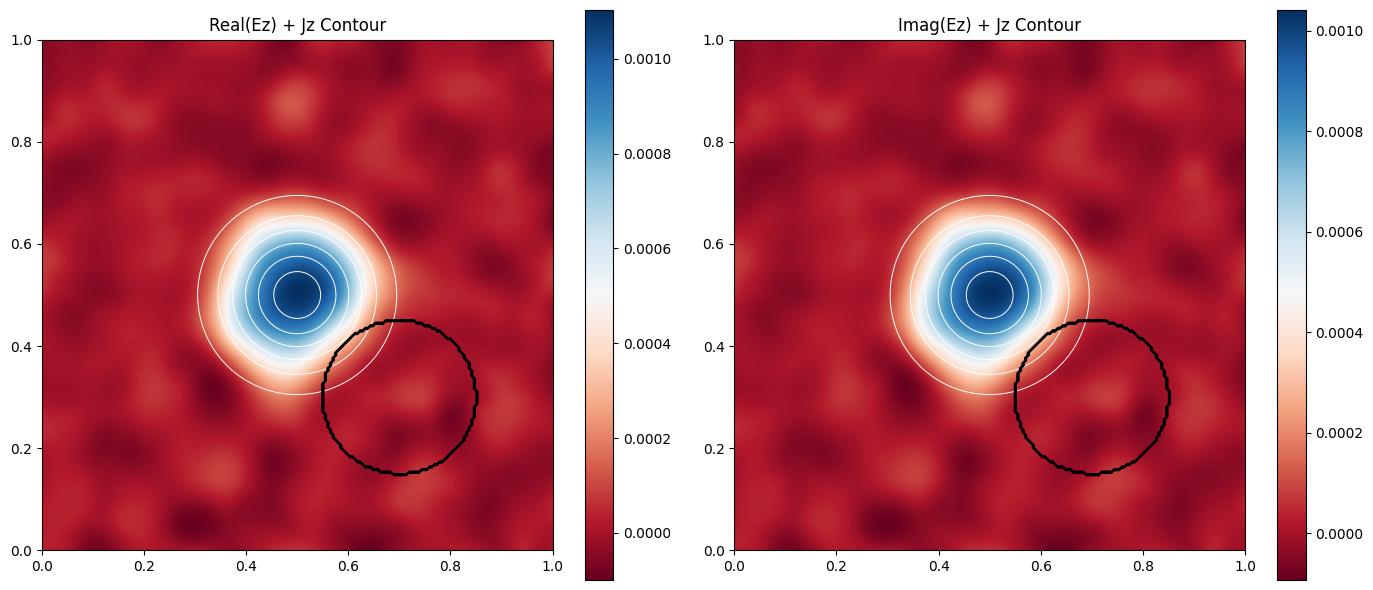

✅ General Helmholtz PINN run complete with complex source & Jz contours.


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

# ===============================================
# 🔵 Sine Layer for PINN
# ===============================================
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1/self.linear.in_features, 1/self.linear.in_features)
            else:
                bound = np.sqrt(6/self.linear.in_features) / self.omega_0
                self.linear.weight.uniform_(-bound, bound)

    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

# ===============================================
# 🔵 General Helmholtz PINN (isotropic, VTI, TTI)
# ===============================================
class GeneralHelmholtzPINN(nn.Module):
    def __init__(self, layers, omega, mode="isotropic", theta0=0.0):
        super(GeneralHelmholtzPINN, self).__init__()
        self.omega = omega
        self.mode = mode
        self.theta0 = theta0
        net = []
        for i in range(len(layers)-2):
            net.append(SineLayer(layers[i], layers[i+1], is_first=(i==0)))
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*net)

    def forward(self, xz):
        return self.model(xz)

    def residual(self, x, z, epsilon, ps, pml_sigma=None):
        """Compute Helmholtz residual with optional PML damping."""
        xz = torch.cat([x, z], dim=1)
        outputs = self.forward(xz)
        u_r, u_i = outputs[:, 0:1], outputs[:, 1:2]

        # First derivatives
        dudx_r = torch.autograd.grad(u_r, x, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
        dudx_i = torch.autograd.grad(u_i, x, grad_outputs=torch.ones_like(u_i), create_graph=True)[0]
        dudz_r = torch.autograd.grad(u_r, z, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
        dudz_i = torch.autograd.grad(u_i, z, grad_outputs=torch.ones_like(u_i), create_graph=True)[0]

        # Second derivatives
        dudxx_r = torch.autograd.grad(dudx_r, x, grad_outputs=torch.ones_like(dudx_r), create_graph=True)[0]
        dudxx_i = torch.autograd.grad(dudx_i, x, grad_outputs=torch.ones_like(dudx_i), create_graph=True)[0]
        dudzz_r = torch.autograd.grad(dudz_r, z, grad_outputs=torch.ones_like(dudz_r), create_graph=True)[0]
        dudzz_i = torch.autograd.grad(dudz_i, z, grad_outputs=torch.ones_like(dudz_i), create_graph=True)[0]

        # Helmholtz residual (real & imaginary)
        u_loss_r = dudxx_r + dudzz_r + (self.omega**2) * epsilon * u_r - ps.real
        u_loss_i = dudxx_i + dudzz_i + (self.omega**2) * epsilon * u_i - ps.imag

        # Optional PML damping
        if pml_sigma is not None:
            u_loss_r += pml_sigma * u_r
            u_loss_i += pml_sigma * u_i

        return u_loss_r, u_loss_i

# ===============================================
# 🔽 Domain setup
# ===============================================
def generate_domain(nx=100, ny=100, case_type="circle"):
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)
    epsilon = np.ones((ny, nx), dtype=np.float32)

    if case_type == "circle":
        inside = (X - 0.7)**2 + (Y - 0.3)**2 < 0.15**2
        epsilon[inside] = 2.0
    elif case_type == "square":
        inside = (X > 0.35) & (X < 0.65) & (Y > 0.35) & (Y < 0.65)
        epsilon[inside] = 2.0
    elif case_type == "topography":
        surface = 0.5 + 0.1 * np.sin(2 * np.pi * X)
        for i in range(ny):
            for j in range(nx):
                if Y[i, j] < surface[i, j]:
                    epsilon[i, j] = 10.0

    return X, Y, epsilon

# ===============================================
# 🔽 Training template
# ===============================================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🔥 Using device: {device}")

    case_type = "circle"
    nx, ny = 200, 200
    X, Y, eps_grid = generate_domain(nx, ny, case_type)

    # ✅ Complex Gaussian source (forces imaginary field)
    ps = np.exp(-((X-0.5)**2 + (Y-0.5)**2)/(2*0.01)) * (1 + 1j)
    ps = ps.astype(np.complex64)

    # ✅ PML damping near edges
    sigma = np.zeros_like(X, dtype=np.float32)
    pml_width = 20
    sigma[:pml_width, :] = np.linspace(1, 0, pml_width)[:, None]
    sigma[-pml_width:, :] = np.linspace(0, 1, pml_width)[:, None]
    sigma[:, :pml_width] = np.maximum(sigma[:, :pml_width], np.linspace(1, 0, pml_width)[None, :])
    sigma[:, -pml_width:] = np.maximum(sigma[:, -pml_width:], np.linspace(0, 1, pml_width)[None, :])

    # ✅ Flatten data
    x_flat = X.flatten()[:, None].astype(np.float32)
    y_flat = Y.flatten()[:, None].astype(np.float32)
    eps_flat = eps_grid.flatten()[:, None]
    ps_flat = ps.flatten()[:, None]
    sigma_flat = sigma.flatten()[:, None]

    # ✅ Torch tensors
    x_train = torch.tensor(x_flat, dtype=torch.float32, requires_grad=True).to(device)
    y_train = torch.tensor(y_flat, dtype=torch.float32, requires_grad=True).to(device)
    eps_train = torch.tensor(eps_flat, dtype=torch.float32).to(device)
    ps_train = torch.tensor(ps_flat, dtype=torch.complex64).to(device)
    sigma_train = torch.tensor(sigma_flat, dtype=torch.float32).to(device)

    # ✅ Boundary points
    boundary_idx = np.where((X.flatten()==0) | (X.flatten()==1) | (Y.flatten()==0) | (Y.flatten()==1))[0]
    boundary_x = torch.tensor(x_flat[boundary_idx], dtype=torch.float32, requires_grad=True).to(device)
    boundary_y = torch.tensor(y_flat[boundary_idx], dtype=torch.float32, requires_grad=True).to(device)

    # 🏗 Model
    layers = [2, 50, 50, 50, 50, 2]
    omega = 2*np.pi*5.0
    model = GeneralHelmholtzPINN(layers, omega).to(device)

    # 🔧 Optimizer
    adam = optim.Adam(model.parameters(), lr=1e-3)
    losses = []

    # 🔵 Training
    for it in range(32000):
        adam.zero_grad()

        u_loss_r, u_loss_i = model.residual(x_train, y_train, eps_train, ps_train, pml_sigma=sigma_train)
        pde_loss = torch.mean(u_loss_r**2) + torch.mean(u_loss_i**2)

        # Boundary condition loss
        Ez_boundary = model(torch.cat([boundary_x, boundary_y], dim=1))
        bc_loss = torch.mean(Ez_boundary[:, 0]**2 + Ez_boundary[:, 1]**2)

        # Source region loss
        source_idx = np.where(ps_flat.real.flatten() > 0.1)[0]
        src_x = torch.tensor(x_flat[source_idx], dtype=torch.float32, requires_grad=True).to(device)
        src_y = torch.tensor(y_flat[source_idx], dtype=torch.float32, requires_grad=True).to(device)
        Ez_src = model(torch.cat([src_x, src_y], dim=1))
        src_loss = torch.mean((Ez_src[:,0] - 1.0)**2)

        loss = pde_loss + 10.0*bc_loss + 5.0*src_loss
        loss.backward()
        adam.step()
        losses.append(loss.item())

        if it % 2000 == 0:
            print(f"Iter {it}, Total Loss: {loss.item():.3e}, PDE: {pde_loss.item():.3e}, BC: {bc_loss.item():.3e}, SRC: {src_loss.item():.3e}")

    # ✅ Predict Ez
    with torch.no_grad():
        Ez_pred = model(torch.cat([x_train, y_train], dim=1))
        Ez_real = Ez_pred[:, 0].cpu().numpy().reshape(X.shape)
        Ez_imag = Ez_pred[:, 1].cpu().numpy().reshape(X.shape)

    # ✅ Plot Real & Imag with source (Jz) contours
    fig, axs = plt.subplots(1, 2, figsize=(14,6))

    im0 = axs[0].imshow(Ez_real, extent=[0, 1, 0, 1], origin='lower', cmap='RdBu')
    axs[0].contour(X, Y, ps.real, colors='white', linewidths=0.7)  # Jz contour
    axs[0].contour(X, Y, eps_grid.real, colors='black', linewidths=0.7)  # Jz contour
    axs[0].set_title('Real(Ez) + Jz Contour')
    plt.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(Ez_imag, extent=[0, 1, 0, 1], origin='lower', cmap='RdBu')
    axs[1].contour(X, Y, ps.real, colors='white', linewidths=0.7)  # Jz contour
    axs[1].contour(X, Y, eps_grid.real, colors='black', linewidths=0.7)  # Jz contour
    axs[1].set_title('Imag(Ez) + Jz Contour')
    plt.colorbar(im1, ax=axs[1])

    plt.tight_layout()
    plt.show()

    print("✅ General Helmholtz PINN run complete with complex source & Jz contours.")
